<a href="https://colab.research.google.com/github/ThisIsJorgeLima/DS-Unit-2-Kaggle-Challenge/blob/master/module4/JAL_Dec_12__assignment_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [58]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group','num_private']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 
                       'latitude', 'gps_height', 'population','amount_tsh']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
     RandomForestClassifier(n_estimators=100,max_depth=25, random_state=0)
    #RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Our Train Accuracy is:', pipeline.score(X_train, y_train))
print('Our Validation Accuracy is', accuracy_score(y_val, y_pred))

Our Train Accuracy is: 0.9916300341903113
Our Validation Accuracy is 0.8111157542833264


### Scikit-learn's confusion matrix function

In [59]:
import sklearn
sklearn.__version__

'0.21.3'

In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[7023,  150,  625],
       [ 563,  320,  160],
       [1161,   53, 4303]])

In [61]:
# Lets get our labels:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [62]:
# 1. Check that our labels are correct
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}'for label in labels]
  index = [f'Actual {label}' for label in labels]
  return columns, index

plot_confusion_matrix(y_val, y_pred)


(['Predicted functional',
  'Predicted functional needs repair',
  'Predicted non functional'],
 ['Actual functional',
  'Actual functional needs repair',
  'Actual non functional'])

In [63]:
# 2. Make it a pandas dateframe
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actural {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=columns, index=index)
  
  return table

plot_confusion_matrix(y_val, y_pred)

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actural functional,7023,150,625
Actural functional needs repair,563,320,160
Actural non functional,1161,53,4303


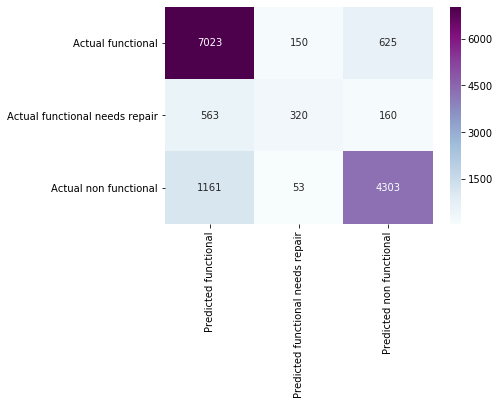

In [64]:
# 3. Plot a heatmap
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='BuPu')

plot_confusion_matrix(y_val, y_pred)
plt.show()

In [65]:
# Note to self: Correct predictions is calculated Diagonally across. 
correct_predictions = 7023 + 320 + 4303
print ('The Correct Predcition is:', (correct_predictions))

# Note to self: entire heatmap total:
total_predictions = 7023 + 150 + 625 + 563 + 320 + 160 + 1161 + 53 + 4303,
print('The Total Predctions is:', (total_predictions))

# Classifcation Accuracy:
correct_predictions = 11646
total_predictions = 14358
print('The Classification Accuracy is:',correct_predictions / total_predictions)

# Accuracy_score:
print('The Accuracy Score is:',accuracy_score(y_val, y_pred))

#Sum
print ('The Sum is:', sum(y_pred == y_val) / len(y_pred))

The Correct Predcition is: 11646
The Total Predctions is: (14358,)
The Classification Accuracy is: 0.8111157542833264
The Accuracy Score is: 0.8111157542833264
The Sum is: 0.8111157542833264


Classification metrics: precision, recall

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      7798
functional needs repair       0.61      0.31      0.41      1043
         non functional       0.85      0.78      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.66      0.69     14358
           weighted avg       0.81      0.81      0.80     14358



Confusion Matrix Plot

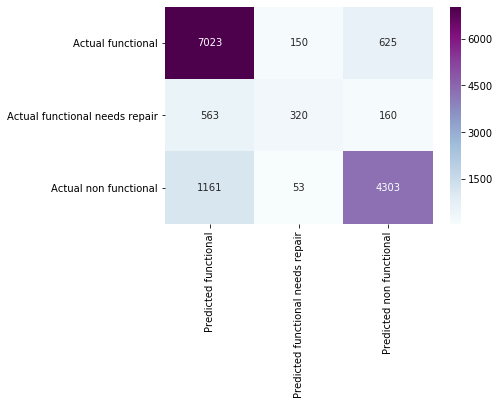

In [67]:
plot_confusion_matrix(y_val, y_pred)
plt.show()

In [68]:
# Find the Correct Predictions "Non functional"
correct_predictions_nonfunctional = 4303
print('The Correct Predictions Non-functional is:', correct_predictions_nonfunctional) 

# Find the total prediction of "Non functional"
total_predictions_nonfunctional = 4303 + 160 + 625
print('The Total Predictions Non-functional is:', total_predictions_nonfunctional)

# The Precision for "Non functional":
correct_predictions_nonfunctional = 4303
total_predictions_nonfunctional = 4303 + 160 + 625
print('The Precision for Non functional:', correct_predictions_nonfunctional / total_predictions_nonfunctional)

The Correct Predictions Non-functional is: 4303
The Total Predictions Non-functional is: 5088
The Precision for Non functional: 0.8457154088050315


In [69]:
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      7798
functional needs repair       0.61      0.31      0.41      1043
         non functional       0.85      0.78      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.66      0.69     14358
           weighted avg       0.81      0.81      0.80     14358



In [70]:
# Actual "Non functional" waterpumps:
actual_nonfunctional = 1161 + 53 + 4303
print ('The Actual Non-functional waterpumps are:', actual_nonfunctional)

# The recall for "Non functional"
print ('The recall for Non-functional:', correct_predictions_nonfunctional / actual_nonfunctional)

The Actual Non-functional waterpumps are: 5517
The recall for Non-functional: 0.779952872938191


In [71]:
len(test)

14358

In [72]:
len(train)+ len(val)

59400

In [73]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [74]:
2000 * 0.46

920.0

In [75]:
# Lets identify which waterpumps are non-functional 
#or are functional but need repari:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

In [76]:
# We are setting the same size as our test set.
len(val) == len(test)

True

In [0]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

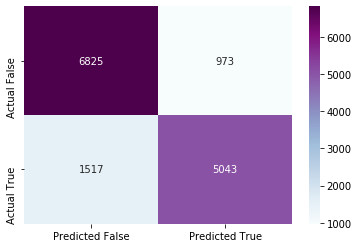

In [78]:
plot_confusion_matrix(y_val, y_pred);

In [0]:
# How many total predictions of "True"("non functional" or "functional needs repair")

In [79]:
5043 + 977

6020

In [80]:
# Discrete predictions:
pipeline.predict(X_val)

array([ True,  True, False, ..., False,  True, False])

In [81]:
# Predicted probabilities:
pipeline.predict_proba(X_val)

array([[0.01      , 0.99      ],
       [0.26556043, 0.73443957],
       [0.94      , 0.06      ],
       ...,
       [0.81585768, 0.18414232],
       [0.47906794, 0.52093206],
       [1.        , 0.        ]])

In [82]:
# Predicted probabilities:
pipeline.predict_proba(X_val)[:, 1]

array([0.99      , 0.73443957, 0.06      , ..., 0.18414232, 0.52093206,
       0.        ])

In [83]:
# Make predicted probabilities into discrete predictions,
# using a "threshold"
pipeline.predict_proba(X_val)[:, 1] > 0.5

array([ True,  True, False, ..., False,  True, False])

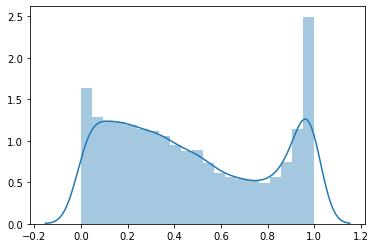

In [84]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
sns.distplot(y_pred_proba)
plt.show()

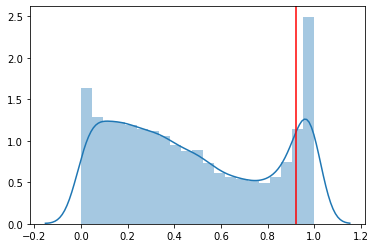

In [88]:
threshold = 0.92

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts
plt.show()

In [89]:
from ipywidgets import interact, fixed

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0, 1, 0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [90]:
results = pd.DataFrame({'y_val': y_val, 'y_pred_proba': y_pred_proba})
results

,y_val,y_pred_proba
58046,True,0.990000
41184,True,0.734440
27587,False,0.060000
53109,False,0.031508
7245,True,0.697588
...,...,...
18760,False,0.646749
36059,True,0.920000
4759,False,0.184142
43621,False,0.520932


In [92]:
top2000 = results.sort_values(by='y_pred_proba', ascending=False)[:2000]
top2000.sample(n=50)

,y_val,y_pred_proba
8280,True,0.950000
54537,True,0.969083
38692,True,0.960000
22840,True,0.988458
18932,True,1.000000
2897,True,0.970000
52418,True,1.000000
55826,True,1.000000
19976,True,0.949906
5959,True,0.960049


In [95]:
# Lets see how many of our recs were relevant?
trips = 2000
print(f'Baseline: {trips * 0.46} waterpump repairs in {trips} trips')

relevant_recommendations = top2000['y_val'].sum()
print(f'With model: Predict {relevant_recommendations} waterpump repairs in {trips} trips')

Baseline: 920.0 waterpump repairs in 2000 trips
With model: Predict 1983 waterpump repairs in 2000 trips


In [99]:
# This is the precision for this subset of 2k predictions:
precision_at_k_2000 = relevant_recommendations / trips
print('Precision @ k=2000', precision_at_k_2000)

Precision @ k=2000 0.9915


In [0]:
my_submission = sample_submission.copy()
my_submission['status_group'] = y_pred
my_submission.to_csv('JAL_Dec_13_Kaggle_Challenge_2.csv', index=False)

from google.colab import files
files.download('JAL_Dec_13_Kaggle_Challenge_2.csv')